# Lidar - GEDI
### AGB prediction script

-----

>Rob Burger

>Space4Good

>Biomass estimation in Tanzania

In [3]:
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.utils import resample

C:\Users\robur\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Read in data

Read in Zonal statistics file from ProcessGEDI notebook script

In [4]:
# Read in zonal statistics GEOJSON of GEDI buffer points

#gdf = gpd.read_file("../../data/processed/lidarGEDIZonalstats.geojson")
gdf = gpd.read_file("../../../data/processed/lidarGEDIforestZonalStats.geojson")
# gdf = gpd.read_file("../../data/processed/lidarGEDIforestZonalStats_2020.geojson")

In [7]:
len(gdf)

233

In [ ]:
# ---

In [8]:
# Statistics to compute (only use the ones that arised after feature selection)

features=['min','max','mean','std','sum','percentile_10',
       'percentile_20','percentile_30','percentile_40',
       'percentile_50','percentile_60','percentile_70',
       'percentile_75','percentile_80','percentile_85',
       'percentile_90','percentile_95','percentile_98']

# features = ["percentile_98","percentile_90","percentile_80","percentile_60","percentile_30","percentile_10"]


cols = ["agbd", *(features)]
gdf = gdf[cols]
gdf

,agbd,min,max,mean,std,sum,percentile_10,percentile_20,percentile_30,percentile_40,percentile_50,percentile_60,percentile_70,percentile_75,percentile_80,percentile_85,percentile_90,percentile_95,percentile_98
0,10.794104,-0.000,5.514000,0.670664,1.057991,4524.297852,-0.0000,0.0000,0.0230,0.0630,0.1350,0.2970,0.6610,0.90475,1.1940,1.61800,2.2660,3.12925,4.04910
1,12.361265,-0.000,6.347000,0.684340,0.990610,6638.783203,0.0000,0.0000,0.0070,0.0530,0.1430,0.3980,0.8060,1.05100,1.4070,1.84100,2.2810,2.72300,3.32700
2,13.198904,-0.000,6.130000,0.510063,0.993402,4948.119141,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1010,0.46400,0.9500,1.51800,2.1800,2.97000,3.59700
3,14.833140,-0.002,5.537000,0.340241,0.908846,3267.672852,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.00000,0.0290,0.43310,1.4637,2.83070,3.64482
4,13.405437,-0.000,7.229000,0.740263,1.336044,3943.380127,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0380,0.4452,0.95050,1.5122,2.25620,2.9920,3.71110,4.67928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,32.620262,-0.000,17.875999,4.181367,4.611092,35687.964844,0.0000,0.0090,0.5312,1.5816,2.3840,3.2478,5.4756,7.57600,8.9984,10.38100,11.8406,13.48560,14.91116
229,11.370763,-0.001,15.346000,3.026822,2.774334,24692.812500,-0.0000,0.1368,1.1221,2.3370,2.9300,3.3490,3.7830,4.08350,4.5066,5.21145,6.2400,8.55815,10.96982
230,38.202065,-0.005,15.555000,2.777313,3.827847,21807.462891,0.0000,0.0000,0.0000,0.1804,1.1695,2.4156,3.1860,3.62100,4.4720,6.70740,8.7814,12.29905,14.34276
231,26.546700,-0.000,12.285000,2.280301,2.580155,14438.863281,0.0000,0.0000,0.0000,0.0054,1.0100,3.0866,3.9410,4.30450,4.7238,5.25235,5.7205,6.62845,8.53590


## Data exploration + cleaning

Data exploration done by checking the correlations, scatterplots, and data filtering

In [9]:
gdf.corr()['agbd'][:]

agbd             1.000000
min              0.257542
max              0.325708
mean             0.562001
std              0.462415
sum              0.504537
percentile_10    0.393018
percentile_20    0.447467
percentile_30    0.464515
percentile_40    0.463623
percentile_50    0.480634
percentile_60    0.519563
percentile_70    0.556918
percentile_75    0.566592
percentile_80    0.574582
percentile_85    0.555721
percentile_90    0.516776
percentile_95    0.462540
percentile_98    0.387430
Name: agbd, dtype: float64

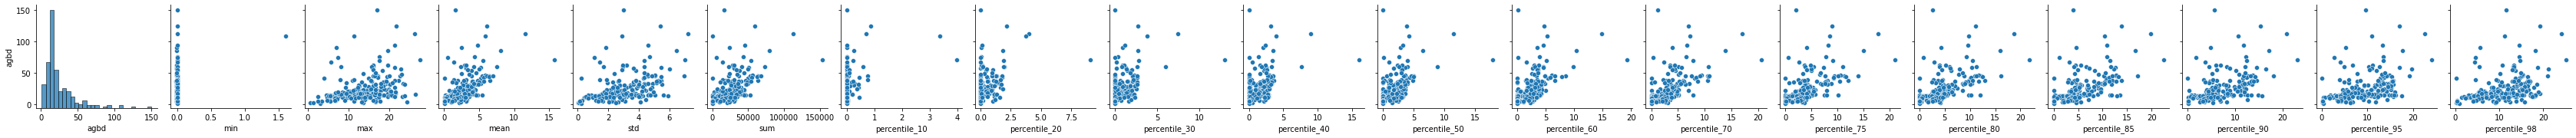

In [10]:
sns.pairplot(gdf, y_vars="agbd", x_vars=gdf.columns.values)

In [12]:
df = gdf[gdf.agbd <= 2000]
df.corr()['agbd'][:]

agbd             1.000000
min              0.257542
max              0.325708
mean             0.562001
std              0.462415
sum              0.504537
percentile_10    0.393018
percentile_20    0.447467
percentile_30    0.464515
percentile_40    0.463623
percentile_50    0.480634
percentile_60    0.519563
percentile_70    0.556918
percentile_75    0.566592
percentile_80    0.574582
percentile_85    0.555721
percentile_90    0.516776
percentile_95    0.462540
percentile_98    0.387430
Name: agbd, dtype: float64

In [13]:
# Remove unnecessary features
# Low correlations, and illogical scatterplot

df = df.drop(columns=["min", "max", "sum", "percentile_10", "percentile_20","percentile_30","percentile_40"], axis=1)

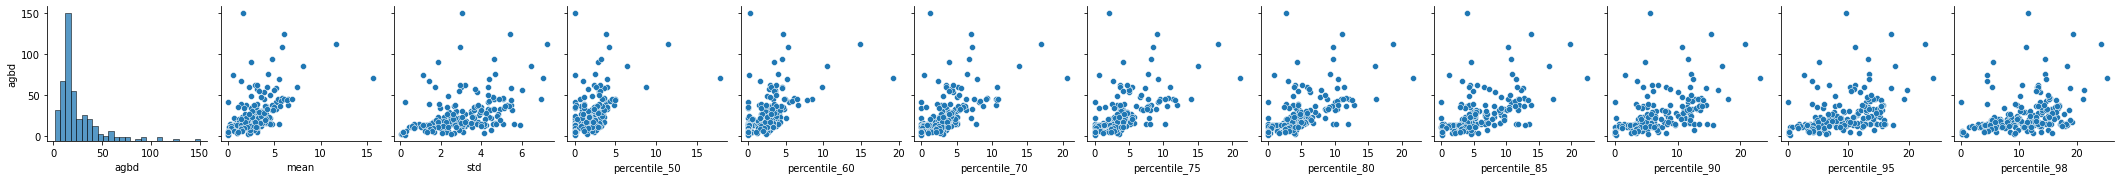

In [32]:
sns.pairplot(df, y_vars="agbd", x_vars=df.columns.values)

In [14]:
df.corr("spearman")["agbd"][:]

agbd             1.000000
mean             0.646075
std              0.548486
percentile_50    0.575256
percentile_60    0.620351
percentile_70    0.655068
percentile_75    0.664453
percentile_80    0.673804
percentile_85    0.646253
percentile_90    0.616527
percentile_95    0.562459
percentile_98    0.474318
Name: agbd, dtype: float64

<AxesSubplot:xlabel='percentile_95', ylabel='agbd'>

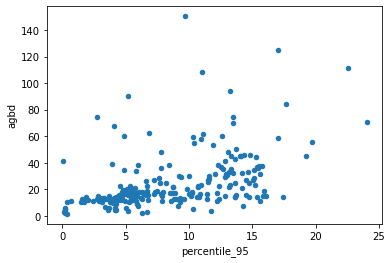

In [33]:
df.plot.scatter("percentile_95","agbd")

## Data cleaning (outlier removal)

Manually removing outliers based on correlations and scatterplots

agbd             1.000000
mean             0.742618
std              0.655545
percentile_50    0.640405
percentile_60    0.691832
percentile_70    0.735998
percentile_75    0.749967
percentile_80    0.767461
percentile_85    0.746576
percentile_90    0.722340
percentile_95    0.673061
percentile_98    0.577809
Name: agbd, dtype: float64

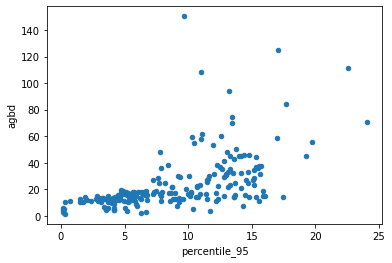

In [15]:
# Apply some filters to remove outliers

temp = df[~((df["agbd"] > 20) & (df["percentile_95"] < 7))]
temp[temp.agbd < 40000].plot.scatter("percentile_95","agbd")
temp.corr("spearman")["agbd"][:]

# looks like it improves the correlations

agbd             1.000000
mean             0.772882
std              0.714966
percentile_50    0.648116
percentile_60    0.701806
percentile_70    0.750615
percentile_75    0.768103
percentile_80    0.787875
percentile_85    0.785919
percentile_90    0.771256
percentile_95    0.745450
percentile_98    0.642797
Name: agbd, dtype: float64

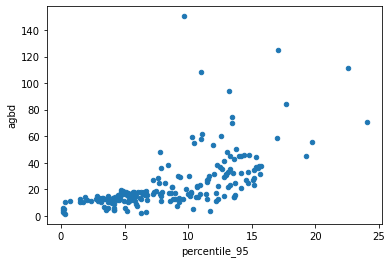

In [16]:
temp = temp[~((temp["agbd"] < 20) & (temp["percentile_95"] > 14))]
temp[temp.agbd < 40000].plot.scatter("percentile_95","agbd")
temp.corr("spearman")["agbd"][:]


agbd             1.000000
mean             0.779925
std              0.717258
percentile_50    0.660555
percentile_60    0.710453
percentile_70    0.759895
percentile_75    0.777936
percentile_80    0.798108
percentile_85    0.791873
percentile_90    0.772857
percentile_95    0.747184
percentile_98    0.648541
Name: agbd, dtype: float64

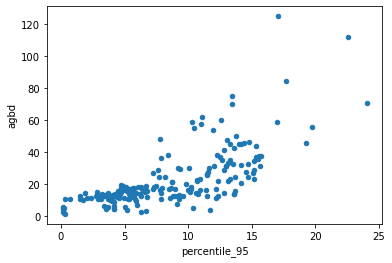

In [17]:
temp = temp[~((temp["agbd"] > 80) & (temp["percentile_95"] < 15))]
temp[temp.agbd < 40000].plot.scatter("percentile_95","agbd")
temp.corr("spearman")["agbd"][:]


<AxesSubplot:xlabel='percentile_85', ylabel='agbd'>

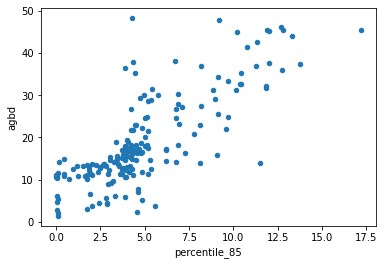

In [18]:
temp[temp.agbd < 50].plot.scatter("percentile_85","agbd")


agbd             1.000000
mean             0.774563
std              0.710386
percentile_50    0.647572
percentile_60    0.700968
percentile_70    0.753887
percentile_75    0.773552
percentile_80    0.795071
percentile_85    0.787685
percentile_90    0.767212
percentile_95    0.740288
percentile_98    0.641924
Name: agbd, dtype: float64

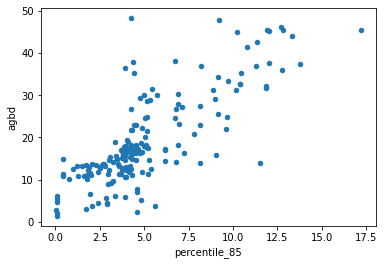

In [19]:
temp = temp[~((temp["agbd"] > 8) & (temp["percentile_85"] < 0.2))]
temp[temp.agbd < 50].plot.scatter("percentile_85","agbd")
temp.corr("spearman")["agbd"][:]

agbd             1.000000
mean             0.785462
std              0.742329
percentile_50    0.639287
percentile_60    0.695389
percentile_70    0.756282
percentile_75    0.778771
percentile_80    0.806008
percentile_85    0.807144
percentile_90    0.782680
percentile_95    0.757132
percentile_98    0.676062
Name: agbd, dtype: float64

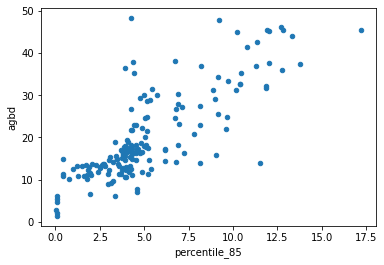

In [20]:
temp = temp[~((temp["agbd"] < 6) & (temp["percentile_85"] > 1.5))]
temp[temp.agbd < 50].plot.scatter("percentile_85","agbd")
temp.corr("spearman")["agbd"][:]

In [22]:
import numpy as np

In [34]:
# Data
x = temp.loc[:, temp.columns != 'agbd']
y = temp["agbd"]

## Optional: outlier removal techniques based on IQR method


In [25]:
# calculate interquartile range
q25, q75 = np.percentile(y, 25), np.percentile(y, 75)
iqr = q75 - q25
iqr
print(q25, q75)

# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print("Min:", round(lower), "\nMax:", round(upper))

# reset index to properly filter
y = y.reset_index(drop=True)
x = x.reset_index(drop=True)

outliers = [i for i,t in enumerate(y) if t < lower or t > upper]


# outliers = []
# for i,t in enumerate(y):
#     #print(i)
#     if t < lower or t > upper:
#         #print(t)
#         outliers.append(y[y==t].index[0])

print('Identified outliers: %d' % len(outliers))


12.892598152160645 30.339580535888672
Min: -13 
Max: 57
Identified outliers: 19


In [26]:
len(df)

233

In [29]:
len(y)

233

In [30]:
print("Number of outliers detected:", len(outliers))
print("\nOutliers their AGB (Mg/ha):", [ round(elem) for elem in y[y.index.isin(outliers)].values.tolist() ] )

Number of outliers detected: 19

Outliers their AGB (Mg/ha): [75, 59, 112, 71, 150, 85, 62, 58, 58, 125, 70, 60, 62, 60, 90, 67, 94, 74, 109]


In [22]:
# Filter outliers

y = y[~y.index.isin(outliers)]
x = x[~x.index.isin(outliers)]
logy = np.log(y)

len(y)

214

<AxesSubplot:>

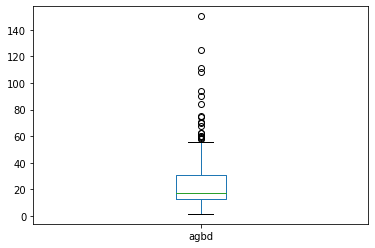

In [31]:
y.plot.box()

# Machine Learning

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib.pyplot as plt
import numpy as np

In [33]:
import statsmodels.api as sm
import pylab
from scipy.stats import skew

In [71]:
def plot_predictions(ytest,ypred):
    
    plt.figure(figsize=(10,10))
    plt.scatter(ytest, ypred, c='crimson')
    # plt.yscale('log')
    # plt.xscale('log')
    plt.grid()
    plt.xticks([0,20,40,60,80,100,120], fontsize=20)
    plt.yticks([0,20,40,60,80,100,120], fontsize=20)
    
    p1 = max(max(ypred), max(ytest))
    p2 = min(min(ypred), min(ytest))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Reference biomass (Mg/ha)', fontsize=24, labelpad=10)
    plt.ylabel('Predicted biomass (Mg/ha)', fontsize=24, labelpad=10)
    plt.axis('equal')
    
    z = np.polyfit(ytest, ypred, 1)
    y_hat = np.poly1d(z)(ytest)
    plt.plot(ytest, y_hat, "r--", lw=1)
    plt.show()

In [36]:
temp.columns

Index(['agbd', 'mean', 'std', 'percentile_50', 'percentile_60',
       'percentile_70', 'percentile_75', 'percentile_80', 'percentile_85',
       'percentile_90', 'percentile_95', 'percentile_98'],
      dtype='object')

In [35]:
x = temp.drop(["agbd"], axis=1)
y = temp["agbd"]
logy = np.log(y)

In [43]:
# Random Forest
# Original
# Y, Unstratified, No Tuning, No Feat.Selection

i = 0

r2_train_scores = []
rmse_train_scores = []
mape_train_scores = []

r2_scores = []
rmse_scores = []
mape_scores = []

rf = RandomForestRegressor(random_state=3)
# rf = RandomForestRegressor(n_estimators=100, min_samples_split=3, min_samples_leaf=10, 
#                            max_features=5, max_depth=3, bootstrap=True, random_state=3)

# Set-up k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=5)
# kf = KFold(n_splits=k, shuffle=True)

# Loop k (5) times and calculate average of the statistics
for train_index, test_index in kf.split(x,y):
    
    i += 1
    print("Iteration: ", i, " out of ", k)
    
    xtrain, xtest = x.iloc[train_index,:], x.iloc[test_index,:]
    ytrain, ytest = y.iloc[train_index] , y.iloc[test_index]
    
    # Fit RF-regression model on training data
    rf.fit(xtrain,ytrain)
    
    ## Predict on train set
    ytrain_pred = rf.predict(xtrain)
    
#     # Un-log
#     ytrain_pred = np.exp(ytrain_pred)
#     ytrain = np.exp(ytrain)

    # Save scores
    r2_train_scores.append(r2_score(ytrain, ytrain_pred))
    rmse_train_scores.append(mean_squared_error(ytrain, ytrain_pred, squared=False))
    mape_train_scores.append(mean_absolute_percentage_error(ytrain, ytrain_pred))

    ## Predict on test set
    ypred = rf.predict(xtest)
 
    # Un-log
#     ypred = np.exp(ypred)
#     ytest = np.exp(ytest)

    # Save scores
    r2_scores.append(r2_score(ytest, ypred))
    rmse_scores.append(mean_squared_error(ytest, ypred, squared=False))
    mape_scores.append(mean_absolute_percentage_error(ytest, ypred))
    
    
print("Training")
print("All R2:        ",[round(score,2) for score in r2_train_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_train_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_train_scores])

print("Avg R2:        ",str(round(sum(r2_train_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_train_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_train_scores)/k,2)))

print("\nTest")
print("All R2:        ",[round(score,2) for score in r2_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_scores])

print("Avg R2:        ",str(round(sum(r2_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_scores)/k,2)))

Iteration:  1  out of  5
Iteration:  2  out of  5
Iteration:  3  out of  5
Iteration:  4  out of  5
Iteration:  5  out of  5
Training
All R2:         [0.94, 0.93, 0.93, 0.94, 0.93]
All RMSE:       [4.1, 4.9, 4.9, 4.5, 4.7]
All MAPE:       [12.0, 11.7, 12.0, 12.8, 12.9]
Avg R2:         0.93
Avg RMSE:       4.61
Avg MAPE:       12.28

Test
All R2:         [0.45, 0.37, 0.62, 0.46, 0.64]
All RMSE:       [16.9, 11.2, 8.7, 13.3, 10.8]
All MAPE:       [29.3, 44.6, 36.7, 31.8, 25.9]
Avg R2:         0.51
Avg RMSE:       12.2
Avg MAPE:       33.65


### Stratified split on Log-Y
First, use pandas qcut function to split numerical data into bins

Then, use Stratified k-fold cross-validation to split data into similar train and test sets

In [49]:
cat= pd.DataFrame()
# Store continuous and discrete output in dataframe test
cat["y"] = logy

# Categorize with qcut()
results, bin_edges = pd.qcut(logy, q=10, labels=False, precision=0, retbins=True)

# Store continuous output in dataframe test
cat["bin"] = results

# Print number of samples per bin, should be equally-sized
print(cat.bin.value_counts())

# Print all bin edges/thresholds to get a good overview of the bins
np.set_printoptions(suppress=True)
np.round(bin_edges,1)


0    19
1    19
3    19
5    19
7    19
9    19
2    18
4    18
6    18
8    18
Name: bin, dtype: int64


array([0.3, 2.4, 2.5, 2.6, 2.8, 2.8, 2.9, 3.3, 3.5, 3.8, 4.8])

In [56]:
# Set-up stratified k-fold cross-validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=8)

# Define splits beforehand based on sample bin
splits = kf.split(x,cat["bin"])

i = 0

r2_train_scores = []
rmse_train_scores = []
mape_train_scores = []

r2_scores = []
rmse_scores = []
mape_scores = []

rf = RandomForestRegressor(random_state=3)
# rf = RandomForestRegressor(n_estimators=100, min_samples_split=3, min_samples_leaf=10, 
#                            max_features=5, max_depth=3, bootstrap=True, random_state=3)

# Loop k times and split into train and test sets
for n,(train_index,test_index) in enumerate(splits):

    i += 1
    print("Iteration: ", i, " out of ", k)
    
    xtrain_strat, xtest_strat = x.iloc[train_index,:], x.iloc[test_index,:]
    ytrain_strat, ytest_strat = logy.iloc[train_index] , logy.iloc[test_index]
    
    # Fit RF-regression model on training data
    rf.fit(xtrain_strat,ytrain_strat)
    
    ## Predict on train set
    ytrain_pred = pd.Series(rf.predict(xtrain_strat))
    
    # Un-log
    ytrain_pred = np.exp(ytrain_pred)
    ytrain_strat = np.exp(ytrain_strat)
  
    # Save scores
    r2_train_scores.append(r2_score(ytrain_strat, ytrain_pred))
    rmse_train_scores.append(mean_squared_error(ytrain_strat, ytrain_pred, squared=False))
    mape_train_scores.append(mean_absolute_percentage_error(ytrain_strat, ytrain_pred))

    ## Predict on test set
    ypred = pd.Series(rf.predict(xtest_strat))
 
    # Un-log
    ypred = np.exp(ypred)
    ytest_strat = np.exp(ytest_strat)
    
    # Save scores
    r2_scores.append(r2_score(ytest_strat, ypred))
    rmse_scores.append(mean_squared_error(ytest_strat, ypred, squared=False))
    mape_scores.append(mean_absolute_percentage_error(ytest_strat, ypred))
    

print("Training")
print("All R2:        ",[round(score,2) for score in r2_train_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_train_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_train_scores])

print("Avg R2:        ",str(round(sum(r2_train_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_train_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_train_scores)/k,2)))

print("\nTest")
print("All R2:        ",[round(score,2) for score in r2_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_scores])

print("Avg R2:        ",str(round(sum(r2_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_scores)/k,2)))

Iteration:  1  out of  5
Iteration:  2  out of  5
Iteration:  3  out of  5
Iteration:  4  out of  5
Iteration:  5  out of  5
Training
All R2:         [0.89, 0.91, 0.9, 0.92, 0.92]
All RMSE:       [6.2, 5.4, 5.0, 5.0, 5.3]
All MAPE:       [11.4, 10.4, 10.6, 10.1, 10.5]
Avg R2:         0.91
Avg RMSE:       5.37
Avg MAPE:       10.63

Test
All R2:         [0.7, 0.42, 0.51, 0.73, 0.23]
All RMSE:       [7.8, 11.8, 16.6, 10.4, 11.7]
All MAPE:       [20.6, 39.4, 26.9, 29.9, 33.9]
Avg R2:         0.52
Avg RMSE:       11.64
Avg MAPE:       30.15


### Parameter tuning
Parameters have been manually tuned by running code below and checking train and test scores.

Best scoring parameters have been used in the end.

For a more advanced hyperparameter tuning technique, see SentinelGEDI/PredictGEDI script

In [104]:
# Set-up stratified k-fold cross-validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=8)

# Define splits beforehand based on sample bin
splits = kf.split(x,cat["bin"])

i = 0

r2_train_scores = []
rmse_train_scores = []
mape_train_scores = []

r2_scores = []
rmse_scores = []
mape_scores = []

# rf = RandomForestRegressor(random_state=3)
rf = RandomForestRegressor(n_estimators=100, min_samples_split=3, min_samples_leaf=10, 
                           max_features=5, max_depth=3, bootstrap=True, random_state=3)

# Loop k times and split into train and test sets
for n,(train_index,test_index) in enumerate(splits):

    i += 1
    print("Iteration: ", i, " out of ", k)
    
    xtrain_strat, xtest_strat = x.iloc[train_index,:], x.iloc[test_index,:]
    ytrain_strat, ytest_strat = logy.iloc[train_index] , logy.iloc[test_index]
    
    # Fit RF-regression model on training data
    rf.fit(xtrain_strat,ytrain_strat)
    
    ## Predict on train set
    ytrain_pred = pd.Series(rf.predict(xtrain_strat))
    
    # Un-log
    ytrain_pred = np.exp(ytrain_pred)
    ytrain_strat = np.exp(ytrain_strat)
  
    # Save scores
    r2_train_scores.append(r2_score(ytrain_strat, ytrain_pred))
    rmse_train_scores.append(mean_squared_error(ytrain_strat, ytrain_pred, squared=False))
    mape_train_scores.append(mean_absolute_percentage_error(ytrain_strat, ytrain_pred))

    ## Predict on test set
    ypred = pd.Series(rf.predict(xtest_strat))
 
    # Un-log
    ypred = np.exp(ypred)
    ytest_strat = np.exp(ytest_strat)
    
    # Save scores
    r2_scores.append(r2_score(ytest_strat, ypred))
    rmse_scores.append(mean_squared_error(ytest_strat, ypred, squared=False))
    mape_scores.append(mean_absolute_percentage_error(ytest_strat, ypred))
    

print("Training")
print("All R2:        ",[round(score,2) for score in r2_train_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_train_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_train_scores])

print("Avg R2:        ",str(round(sum(r2_train_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_train_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_train_scores)/k,2)))

print("\nTest")
print("All R2:        ",[round(score,2) for score in r2_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_scores])

print("Avg R2:        ",str(round(sum(r2_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_scores)/k,2)))

Iteration:  1  out of  5
Iteration:  2  out of  5
Iteration:  3  out of  5
Iteration:  4  out of  5
Iteration:  5  out of  5
Training
All R2:         [0.57, 0.6, 0.58, 0.59, 0.63]
All RMSE:       [12.3, 11.6, 10.3, 11.1, 11.4]
All MAPE:       [32.1, 27.4, 28.2, 28.6, 29.3]
Avg R2:         0.6
Avg RMSE:       11.35
Avg MAPE:       29.12

Test
All R2:         [0.72, 0.53, 0.5, 0.55, 0.26]
All RMSE:       [7.5, 10.6, 16.9, 13.5, 11.4]
All MAPE:       [20.4, 43.9, 39.9, 29.1, 34.7]
Avg R2:         0.51
Avg RMSE:       11.98
Avg MAPE:       33.59


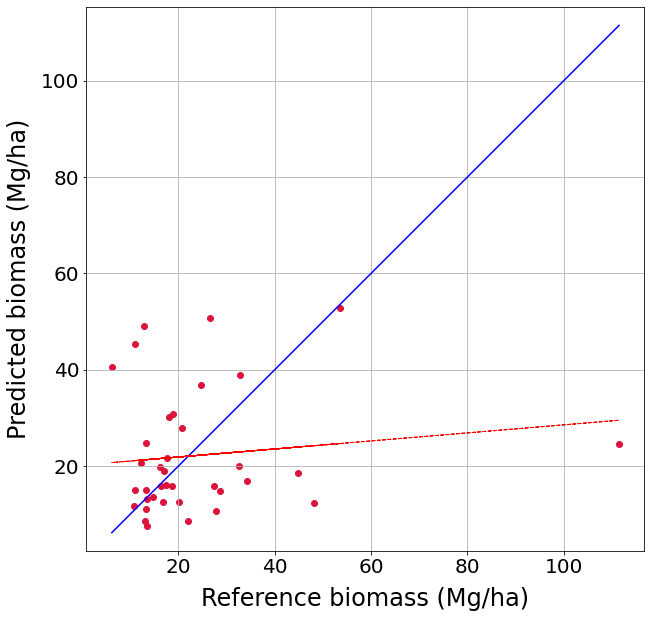

In [103]:
plot_predictions(ytest,ypred)

Train R2:           0.5569781063648032
Train RMSE:         12.42026520743697
Train MAPE:         23.4

Test R2:           0.5137917896783057
Test RMSE:         11.599731568643833
Test MAPE:         48.3


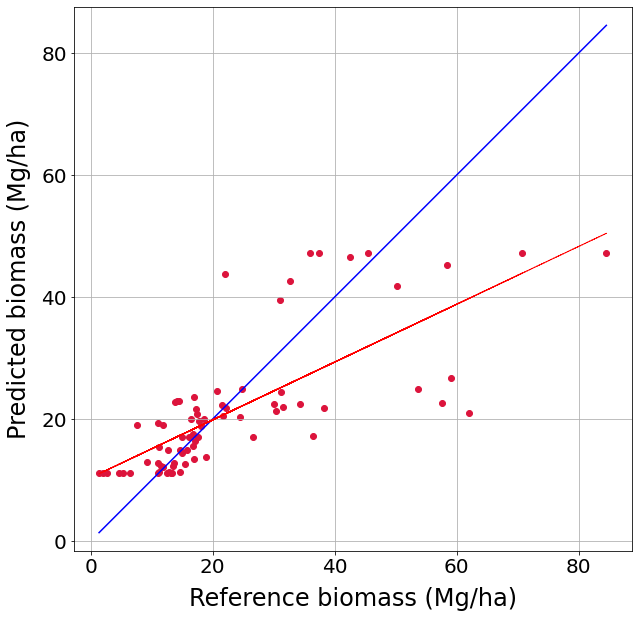

In [198]:
seed = 3
xtrain, xtest, ytrain, ytest = train_test_split(x, logy, test_size=0.4,
                                               stratify = cat["bin"], random_state=4)

# Let's print the number of test samples within each bin, now for the stratified split
(pd.cut(ytest, bins=bin_edges, labels=False).value_counts())

rf = RandomForestRegressor(n_estimators=100, min_samples_split=3, min_samples_leaf=10, 
                           max_features=5, max_depth=3, bootstrap=True, random_state=3)
rf.fit(xtrain,ytrain)

ytrain_pred = rf.predict(xtrain)

# Un-log
ytrain_pred = np.exp(ytrain_pred)
ytrain = np.exp(ytrain)
    
# Save scores
print("Train R2:          ", r2_score(ytrain, ytrain_pred))
print("Train RMSE:        ", mean_squared_error(ytrain, ytrain_pred, squared=False))
print("Train MAPE:        ", round(100*mean_absolute_percentage_error(ytrain, ytrain_pred),1))


## Predict on test set
ypred = rf.predict(xtest)

# Un-log
ypred = np.exp(ypred)
ytest = np.exp(ytest)

# Save scores
print("\nTest R2:          ", r2_score(ytest, ypred))
print("Test RMSE:        ", mean_squared_error(ytest, ypred, squared=False))
print("Test MAPE:        ", round(100*mean_absolute_percentage_error(ytest, ypred),1))

plot_predictions(ytest,ypred)

## XGBoost

In [143]:
from xgboost import XGBRegressor

First run on stratified logy-split

In [147]:
# Set-up stratified k-fold cross-validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=8)

# Define splits beforehand based on sample bin
splits = kf.split(x,cat["bin"])

i = 0

r2_train_scores = []
rmse_train_scores = []
mape_train_scores = []

r2_scores = []
rmse_scores = []
mape_scores = []

xgb = XGBRegressor(random_state=3)

# Loop k times and split into train and test sets
for n,(train_index,test_index) in enumerate(splits):

    i += 1
    print("Iteration: ", i, " out of ", k)
    
    xtrain_strat, xtest_strat = x.iloc[train_index,:], x.iloc[test_index,:]
    ytrain_strat, ytest_strat = logy.iloc[train_index] , logy.iloc[test_index]
    
    # Fit RF-regression model on training data
    xgb.fit(xtrain_strat,ytrain_strat)
    
    ## Predict on train set
    ytrain_pred = pd.Series(xgb.predict(xtrain_strat))
    
    # Un-log
    ytrain_pred = np.exp(ytrain_pred)
    ytrain_strat = np.exp(ytrain_strat)
  
    # Save scores
    r2_train_scores.append(r2_score(ytrain_strat, ytrain_pred))
    rmse_train_scores.append(mean_squared_error(ytrain_strat, ytrain_pred, squared=False))
    mape_train_scores.append(mean_absolute_percentage_error(ytrain_strat, ytrain_pred))

    ## Predict on test set
    ypred = pd.Series(xgb.predict(xtest_strat))
 
    # Un-log
    ypred = np.exp(ypred)
    ytest_strat = np.exp(ytest_strat)
    
    # Save scores
    r2_scores.append(r2_score(ytest_strat, ypred))
    rmse_scores.append(mean_squared_error(ytest_strat, ypred, squared=False))
    mape_scores.append(mean_absolute_percentage_error(ytest_strat, ypred))
    

print("Training")
print("All R2:        ",[round(score,2) for score in r2_train_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_train_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_train_scores])

print("Avg R2:        ",str(round(sum(r2_train_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_train_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_train_scores)/k,2)))

print("\nTest")
print("All R2:        ",[round(score,2) for score in r2_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_scores])

print("Avg R2:        ",str(round(sum(r2_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_scores)/k,2)))

Iteration:  1  out of  5
Iteration:  2  out of  5
Iteration:  3  out of  5
Iteration:  4  out of  5
Iteration:  5  out of  5
Training
All R2:         [1.0, 1.0, 1.0, 1.0, 1.0]
All RMSE:       [0.0, 0.0, 0.0, 0.0, 0.0]
All MAPE:       [0.1, 0.1, 0.1, 0.1, 0.1]
Avg R2:         1.0
Avg RMSE:       0.04
Avg MAPE:       0.08

Test
All R2:         [0.55, 0.29, 0.6, 0.49, 0.1]
All RMSE:       [9.4, 13.1, 15.1, 14.4, 12.6]
All MAPE:       [24.3, 48.0, 33.2, 33.7, 37.8]
Avg R2:         0.41
Avg RMSE:       12.93
Avg MAPE:       35.4


### Hyperparameter tuning XGB

In [210]:
n_estimators = 50
max_depth = 1
subsample = 0.8
colsample_bytree = 0.2
learning_rate = 0.05

parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'learning_rate': learning_rate}



In [224]:
seed = 3
xtrain, xtest, ytrain, ytest = train_test_split(x, logy, test_size=0.3, random_state=seed,
                                               stratify = cat["bin"])

In [225]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV 

# Create custom-made metrics

def rsquared(gt, pred):
    r2 = r2_score(np.exp(gt), np.exp(pred))
    return r2

def rmse_calc(gt, pred):
    rmse = mean_squared_error(np.exp(gt), np.exp(pred), squared=False)
    return rmse

In [212]:
cv_params = {'max_depth': [1,2,4,6,8,10,12,15,18,20,25,30],
            }

r2 = make_scorer(rsquared)
rmse = make_scorer(rmse_calc)
scoring = {"r2": r2, "rmse": rmse}

model = GridSearchCV(XGBRegressor(
                                        random_state = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        learning_rate = learning_rate
                                    ),
                    
                    param_grid = cv_params,
                    scoring = scoring,
                    refit="r2",
                    cv = 5,
                    verbose = 2,
                    return_train_score=True
)

model.fit(xtrain,ytrain)
print ("Best parameters %s" %model.best_params_)
print ("Best score %s" %model.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END .......................................

In [182]:
model.cv_results_

{'mean_fit_time': array([0.0325779 , 0.03475189, 0.03370686, 0.03486714, 0.03673882,
        0.03948808, 0.03851552, 0.04122944, 0.03790679, 0.04135747,
        0.0373877 , 0.04413552]),
 'std_fit_time': array([0.00275505, 0.00298875, 0.00198297, 0.0015333 , 0.00214898,
        0.00172927, 0.00392859, 0.00461909, 0.00123593, 0.00639119,
        0.00247296, 0.00406985]),
 'mean_score_time': array([0.00398183, 0.00631757, 0.00480914, 0.00499735, 0.00465174,
        0.00390725, 0.00342407, 0.00551276, 0.00496664, 0.00436668,
        0.00433125, 0.00424666]),
 'std_score_time': array([0.00108519, 0.00245754, 0.0002474 , 0.00001382, 0.00099167,
        0.00196259, 0.00175269, 0.00257077, 0.0000666 , 0.00132944,
        0.00043116, 0.00317712]),
 'param_max_depth': masked_array(data=[1, 2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype

In [157]:
parameters["max_depth"]=4

In [168]:
cv_params = {'n_estimators': [10,20,50,70,100,150,200,300,400,500],
            }

r2 = make_scorer(rsquared)
rmse = make_scorer(rmse_calc)
scoring = {"r2": r2, "rmse": rmse}

model = GridSearchCV(XGBRegressor(
                                        random_state = seed,
                                        n_estimators = n_estimators,
                                        max_depth = parameters["max_depth"],
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        learning_rate = learning_rate
                                    ),
                    
                    param_grid = cv_params,
                    scoring = scoring,
                    refit="r2",
                    cv = 5,
                    verbose = 2,
                    return_train_score=True
)

model.fit(xtrain,ytrain)
print ("Best parameters %s" %model.best_params_)
print ("Best score %s" %model.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_estimators=20; total time=   0.0s
[CV] END ....................................n_estimators=20; total time=   0.0s
[CV] END ....................................n_estimators=20; total time=   0.0s
[CV] END ....................................n_estimators=20; total time=   0.0s
[CV] END ....................................n_estimators=20; total time=   0.0s
[CV] END ....................................n_estimators=50; total time=   0.0s
[CV] END ....................................n_e

In [169]:
model.cv_results_

{'mean_fit_time': array([0.01332583, 0.02174587, 0.04124217, 0.04719911, 0.06925697,
        0.10148559, 0.1356379 , 0.20140114, 0.29042287, 0.31712542]),
 'std_fit_time': array([0.00077674, 0.0025349 , 0.00584807, 0.00220439, 0.00376592,
        0.00725609, 0.00622034, 0.02353576, 0.01308886, 0.01886826]),
 'mean_score_time': array([0.00519266, 0.00550742, 0.00670781, 0.00475402, 0.00660791,
        0.00559983, 0.00606146, 0.00488062, 0.00659308, 0.0047873 ]),
 'std_score_time': array([0.00040388, 0.00042626, 0.00214409, 0.00038476, 0.00138789,
        0.00050781, 0.00124404, 0.00228182, 0.00153717, 0.000997  ]),
 'param_n_estimators': masked_array(data=[10, 20, 50, 70, 100, 150, 200, 300, 400, 500],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 20},
  {'n_estimators': 50},
  {'n_estimators': 70},
  {'n_estimators': 1

In [170]:
parameters["n_estimators"]=150

In [226]:
cv_params = {'subsample': [.1,.2,.3,.4,.5,.6,.7,.8,.9,1],
            }

r2 = make_scorer(rsquared)
rmse = make_scorer(rmse_calc)
scoring = {"r2": r2, "rmse": rmse}

model = GridSearchCV(XGBRegressor(
                                        random_state = seed,
                                        n_estimators = parameters["n_estimators"],
                                        max_depth = parameters["max_depth"],
                                        subsample = parameters["subsample"],
                                        colsample_bytree = parameters["colsample_bytree"],
                                        learning_rate = parameters["learning_rate"]
                                    ),
                    
                    param_grid = cv_params,
                    scoring = scoring,
                    refit="r2",
                    cv = 5,
                    verbose = 2,
                    return_train_score=True
)

model.fit(xtrain,ytrain)
print ("Best parameters %s" %model.best_params_)
print ("Best score %s" %model.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................................subsample=0.1; total time=   0.0s
[CV] END ......................................subsample=0.1; total time=   0.0s
[CV] END ......................................subsample=0.1; total time=   0.0s
[CV] END ......................................subsample=0.1; total time=   0.0s
[CV] END ......................................subsample=0.1; total time=   0.0s
[CV] END ......................................subsample=0.2; total time=   0.0s
[CV] END ......................................subsample=0.2; total time=   0.0s
[CV] END ......................................subsample=0.2; total time=   0.0s
[CV] END ......................................subsample=0.2; total time=   0.0s
[CV] END ......................................subsample=0.2; total time=   0.0s
[CV] END ......................................subsample=0.3; total time=   0.0s
[CV] END ......................................s

In [227]:
model.cv_results_

{'mean_fit_time': array([0.02964139, 0.03153367, 0.02974691, 0.02878742, 0.02813001,
        0.03094769, 0.0273798 , 0.02731829, 0.03004227, 0.02957931]),
 'std_fit_time': array([0.0007406 , 0.00472528, 0.00146285, 0.00186716, 0.00123079,
        0.00393414, 0.00095441, 0.00134394, 0.00352286, 0.00225818]),
 'mean_score_time': array([0.00559783, 0.00477004, 0.00503478, 0.00398088, 0.00454264,
        0.00479479, 0.00427766, 0.00438223, 0.00524783, 0.00590291]),
 'std_score_time': array([0.00176385, 0.00296416, 0.00167262, 0.00061445, 0.00046969,
        0.00043874, 0.0005174 , 0.00046329, 0.00339597, 0.00339852]),
 'param_subsample': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'subsample': 0.1},
  {'subsample': 0.2},
  {'subsample': 0.3},
  {'subsample': 0.4},
  {'subsample': 0.5},
  {'sub

In [173]:
parameters["subsample"]=0.5

In [178]:
cv_params = {'colsample_bytree': [.2,.3,.5,.6,.7,.8,.9,1],
            }

r2 = make_scorer(rsquared)
rmse = make_scorer(rmse_calc)
scoring = {"r2": r2, "rmse": rmse}

model = GridSearchCV(XGBRegressor(
                                        random_state = seed,
                                        n_estimators = parameters["n_estimators"],
                                        max_depth = parameters["max_depth"],
                                        subsample = parameters["subsample"],
                                        colsample_bytree = parameters["colsample_bytree"],
                                        learning_rate = parameters["learning_rate"]
                                    ),
                    
                    param_grid = cv_params,
                    scoring = scoring,
                    refit="r2",
                    cv = 5,
                    verbose = 2,
                    return_train_score=True
)

model.fit(xtrain,ytrain)
print ("Best parameters %s" %model.best_params_)
print ("Best score %s" %model.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...............................colsample_bytree=0.2; total time=   0.0s
[CV] END ...............................colsample_bytree=0.2; total time=   0.0s
[CV] END ...............................colsample_bytree=0.2; total time=   0.0s
[CV] END ...............................colsample_bytree=0.2; total time=   0.0s
[CV] END ...............................colsample_bytree=0.2; total time=   0.0s
[CV] END ...............................colsample_bytree=0.3; total time=   0.0s
[CV] END ...............................colsample_bytree=0.3; total time=   0.0s
[CV] END ...............................colsample_bytree=0.3; total time=   0.0s
[CV] END ...............................colsample_bytree=0.3; total time=   0.0s
[CV] END ...............................colsample_bytree=0.3; total time=   0.0s
[CV] END ...............................colsample_bytree=0.5; total time=   0.0s
[CV] END ...............................colsample

In [179]:
model.cv_results_

{'mean_fit_time': array([0.09769464, 0.09474854, 0.0990581 , 0.09215732, 0.09904652,
        0.09973326, 0.0930769 , 0.1039876 ]),
 'std_fit_time': array([0.00536345, 0.01085121, 0.00377377, 0.00370184, 0.00802069,
        0.00671224, 0.00298141, 0.00818322]),
 'mean_score_time': array([0.00381184, 0.00479622, 0.00533328, 0.00493345, 0.00559106,
        0.00622387, 0.00497575, 0.00233679]),
 'std_score_time': array([0.00144088, 0.00223419, 0.00260785, 0.00057358, 0.00101355,
        0.00206193, 0.00003719, 0.00202842]),
 'param_colsample_bytree': masked_array(data=[0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'colsample_bytree': 0.2},
  {'colsample_bytree': 0.3},
  {'colsample_bytree': 0.5},
  {'colsample_bytree': 0.6},
  {'colsample_bytree': 0.7},
  {'colsample_bytree': 0.8},
  {'colsample_bytree': 0.9},
  {'colsample_bytree': 1}],
 'split0_test_r2': 

In [223]:
parameters

{'n_estimators': 50,
 'max_depth': 1,
 'subsample': 0.8,
 'colsample_bytree': 0.2,
 'learning_rate': 0.05}

In [232]:
# Set-up stratified k-fold cross-validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=8)

# Define splits beforehand based on sample bin
splits = kf.split(x,cat["bin"])

i = 0

r2_train_scores = []
rmse_train_scores = []
mape_train_scores = []

r2_scores = []
rmse_scores = []
mape_scores = []

# xgb = XGBRegressor(random_state=3)
xgb = XGBRegressor(n_estimators=150, max_depth=4, subsample=.5, colsample_bytree=0.2, 
                   learning_rate=0.05, random_state=3)

# Loop k times and split into train and test sets
for n,(train_index,test_index) in enumerate(splits):

    i += 1
    print("Iteration: ", i, " out of ", k)
    
    xtrain_strat, xtest_strat = x.iloc[train_index,:], x.iloc[test_index,:]
    ytrain_strat, ytest_strat = logy.iloc[train_index] , logy.iloc[test_index]
    
    # Fit RF-regression model on training data
    xgb.fit(xtrain_strat,ytrain_strat)
    
    ## Predict on train set
    ytrain_pred = pd.Series(xgb.predict(xtrain_strat))
    
    # Un-log
    ytrain_pred = np.exp(ytrain_pred)
    ytrain_strat = np.exp(ytrain_strat)
  
    # Save scores
    r2_train_scores.append(r2_score(ytrain_strat, ytrain_pred))
    rmse_train_scores.append(mean_squared_error(ytrain_strat, ytrain_pred, squared=False))
    mape_train_scores.append(mean_absolute_percentage_error(ytrain_strat, ytrain_pred))

    ## Predict on test set
    ypred = pd.Series(xgb.predict(xtest_strat))
 
    # Un-log
    ypred = np.exp(ypred)
    ytest_strat = np.exp(ytest_strat)
    
    # Save scores
    r2_scores.append(r2_score(ytest_strat, ypred))
    rmse_scores.append(mean_squared_error(ytest_strat, ypred, squared=False))
    mape_scores.append(mean_absolute_percentage_error(ytest_strat, ypred))
    

print("Training")
print("All R2:        ",[round(score,2) for score in r2_train_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_train_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_train_scores])

print("Avg R2:        ",str(round(sum(r2_train_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_train_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_train_scores)/k,2)))

print("\nTest")
print("All R2:        ",[round(score,2) for score in r2_scores])
print("All RMSE:      ",[round(score,1) for score in rmse_scores])
print("All MAPE:      ",[round(100*score,1) for score in mape_scores])

print("Avg R2:        ",str(round(sum(r2_scores)/k,2)))
print("Avg RMSE:      ",str(round(sum(rmse_scores)/k,2)))
print("Avg MAPE:      ",str(round(100*sum(mape_scores)/k,2)))

Iteration:  1  out of  5
Iteration:  2  out of  5
Iteration:  3  out of  5
Iteration:  4  out of  5
Iteration:  5  out of  5
Training
All R2:         [0.87, 0.91, 0.88, 0.89, 0.91]
All RMSE:       [6.7, 5.6, 5.5, 5.9, 5.7]
All MAPE:       [13.9, 11.4, 12.1, 11.8, 12.3]
Avg R2:         0.89
Avg RMSE:       5.87
Avg MAPE:       12.29

Test
All R2:         [0.72, 0.42, 0.59, 0.68, 0.3]
All RMSE:       [7.5, 11.8, 15.3, 11.3, 11.2]
All MAPE:       [19.4, 39.0, 28.9, 27.5, 33.4]
Avg R2:         0.54
Avg RMSE:       11.42
Avg MAPE:       29.65


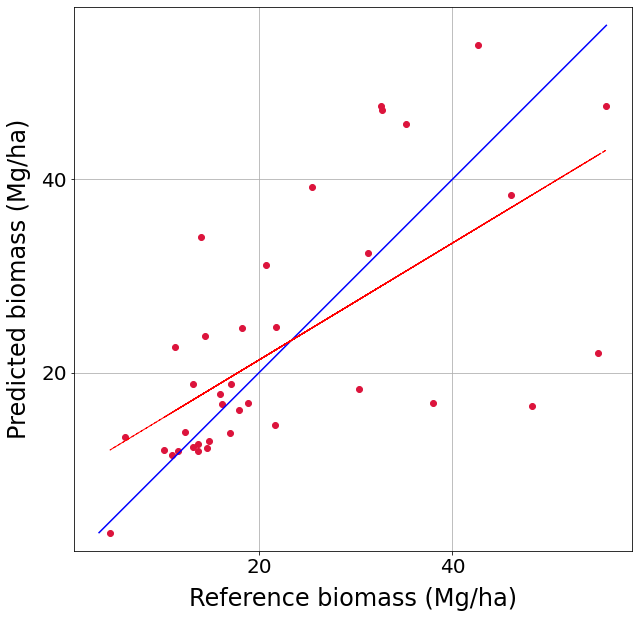

In [234]:
plot_predictions(ytest_strat,ypred)

Train R2:           0.6085019836328325
Train RMSE:         11.675703501247192
Train MAPE:         21.5

Test R2:           0.5769801317718426
Test RMSE:         10.81974879972437
Test MAPE:         43.5


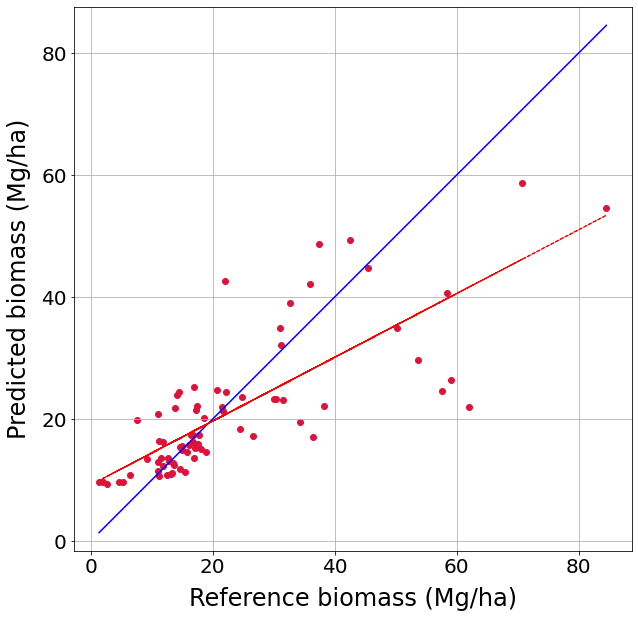

In [237]:
# seed = 3
# xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.4,
#                                                stratify = cat["bin"])
# # Let's print the number of test samples within each bin, now for the stratified split
# (pd.cut(ytest, bins=bin_edges, labels=False).value_counts())
seed = 3
xtrain, xtest, ytrain, ytest = train_test_split(x, logy, test_size=0.4,
                                               stratify = cat["bin"], random_state=4)

xgb = XGBRegressor(n_estimators=150, max_depth=4, subsample=0.1, colsample_bytree=0.2, 
                   learning_rate=0.05, random_state=3)
xgb.fit(xtrain,ytrain)

ytrain_pred = xgb.predict(xtrain)

# Un-log
ytrain_pred = np.exp(ytrain_pred)
ytrain = np.exp(ytrain)

# Save scores
print("Train R2:          ", r2_score(ytrain, ytrain_pred))
print("Train RMSE:        ", mean_squared_error(ytrain, ytrain_pred, squared=False))
print("Train MAPE:        ", round(100*mean_absolute_percentage_error(ytrain, ytrain_pred),1))

## Predict on test set
ypred = xgb.predict(xtest)

# Un-log
ypred = np.exp(ypred)
ytest = np.exp(ytest)
    
# Save scores
print("\nTest R2:          ", r2_score(ytest, ypred))
print("Test RMSE:        ", mean_squared_error(ytest, ypred, squared=False))
print("Test MAPE:        ", round(100*mean_absolute_percentage_error(ytest, ypred),1))

plot_predictions(ytest,ypred)